In [1]:
#pip install contractions
#pip install spacy-cleaner
#pip install spacy - v 3.41

## Start here. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import spacy
import spacy_cleaner
from spacy_cleaner.processing import removers, replacers, mutators

2023-08-03 21:50:13.442810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 21:50:14.641050: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-03 21:50:15.954874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/rkv/miniconda3/envs/tf/lib/
2023-08-03 21:50:15.959229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.s

In [2]:
train_df = pd.read_csv('Data/train.csv')

In [39]:
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [40]:
# Quite fast!
def more_processing(text):
    text = '<sostok> ' + text + ' <eostok>' 
    text = text.lower()
    return text

t1 = time.perf_counter(), time.process_time()
proc_text = [contractions.fix(text) for text in train_df['full_text']]
proc_text_2 = [more_processing(text) for text in proc_text]
t2 = time.perf_counter(), time.process_time()
print(f" Real time: {t2[0] - t1[0] :.2f} seconds")
print(f" CPU time: {t2[1] - t1[1] :.2f} seconds")

 Real time: 0.70 seconds
 CPU time: 0.70 seconds


In [41]:
nlp = spacy.load("en_core_web_md", disable=['senter', 'parser', 'ner'])
#nlp.enable("senter")
print(nlp.pipe_names)

pipeline = spacy_cleaner.Pipeline(
    nlp,
    removers.remove_stopword_token,
    removers.remove_punctuation_token,
    replacers.replace_number_token,
    mutators.mutate_lemma_token,
)

/home/rkv/miniconda3/envs/tf/lib/python3.9/site-packages/spacy/language.py:1895: UserWarning: [W123] Argument disable with value ['senter', 'parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']


In [42]:
# Remember to switch n_process to 4 when running on Kaggle.

proc_text_3 = pipeline.clean(proc_text_2, n_process = 8, batch_size = 12)
# n_process = 4, batch size 12 - 105 it/s : 00:37

# n_process = 8, default batch size - takes forever to initialize
# n_process = 8, batch size 12 - 141 it/s : 00:27
# n_process = 8, batch size 48 - 130 it/s : 00:29

# n_process = 12, default batch size - takes forever to initialize
# n_process = 12, batch size 12 - 120.3 it/s : 00:29
# n_process = 12, batch size 48 - 89.5 it/s : 00:34


Cleaning Progress: 100%|███████████████████████████████████████████████████████████| 3911/3911 [00:23<00:00, 169.11it/s]


In [46]:
# Doing it manually
import time
import re
import string
from nltk.corpus import stopwords #reduce noise and improve the efficiency

#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                        "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                        "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                        "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                        "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                        "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've":
                        "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                        "mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
                        "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                        "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                        "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                        "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not",
                        "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", 
                        "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have",
                        "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                        "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                        "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", 
                        "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                        "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", 
                        "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                        "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", 
                        "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                        "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
                        "y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will",
                        "you'll've": "you will have", "you're": "you are", "you've": "you have"}

#removing contraction
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

def replace_contractions(text):
    text = str(text)
    contractions, contractions_re = _get_contractions(contraction_dict)
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

def add_token(text):
    text = str(text)
    text = 'SOSTOK' + text + 'EOSTOK'
    return text
#https://towardsdatascience.com/using-deep-learning-for-end-to-end-multiclass-text-classification-39b46aecac81

def remove_punct(text):
    text = str(text)
    cleaned_text = text.translate(str.maketrans('', '', string.punctuation))
    return cleaned_text
            
def clean_text(text): 
    stop_words = stopwords.words('english')
    
    text = text.replace(",", " ")
   
    #Replace contractions
    text = replace_contractions(text)
    
    #Remove punctuations
    text = remove_punct(text)
    
    text = nlp(text)

    #Lemmatize text
    lemmatized =  [token.lemma_ for token in text if not str(token).isspace()]  
    
    #Remove stop words
    cleaned_text = [word for word in lemmatized if word not in stop_words]
    cleaned_text = add_token(cleaned_text)
    return cleaned_text

def clean_df(df):
    for index, row in df.iterrows():
        cleaned_text = clean_text(row['full_text'])
        df.at[index, 'full_text'] = cleaned_text

t1 = time.perf_counter(), time.process_time()
clean_df(train_df)
t2 = time.perf_counter(), time.process_time()
print(f" Real time: {t2[0] - t1[0] :.2f} seconds")
print(f" CPU time: {t2[1] - t1[1] :.2f} seconds")
print()

 Real time: 111.34 seconds
 CPU time: 111.34 seconds



#### Using SpaCy + the contractions library took 21-23 seconds, while the ordinary pipeline took 112 - 116 seconds.

#### The regular pipeline was almost 6x slower!!

In [47]:
# Contractions mapped, lemmatized, stopwords and punctuations removed, numbers replaced.
proc_text_3[1]

'< sostok > problem change let good matter happen change mind need wake look problem good way change want change time ago problem change different help understand ting wok different example remember come united states think go change think go change different country realist wrong problem change change way remember shy think change lot problem think thing life need different way let happen rue change want problem example think go change need shy anymore need start see different way mad need know go happened people different way know change good let body change way want change choice problem decide _LIKE_NUM_ help understand thing work instance mom lot problem faith people mom scare high scare high understand mos scare high scare high time mom airplane laugh scare funny different way like high understand hoe thing work people example think mom different understand like high need understand help understand thing work need start thing work person life problem change different help underst

In [48]:
# Also added start of seq and end of seq, lowercase
train_df['cleaned_text'] = proc_text_3

In [9]:
train_df.head()
train_df.to_csv('processed_data_sostok.csv')

In [12]:
# Move back to the EDA pitlane
#import matplotlib.pyplot as plt
#text_count = [len(sentence.split()) for sentence in cleaned_df.text]
#plt.hist(text_count, bins = 100)

In [3]:
train_df = pd.read_csv('processed_data_sostok.csv')

In [13]:
#print(len(nlp.vocab))

23060


In [3]:
train_df.head()

,Unnamed: 0,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cleaned_text
0,0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,< sostok > think student benefit learn home ch...
1,1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,< sostok > problem change let good matter happ...
2,2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,< sostok > dear principal change school policy...
3,3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,< sostok > good time life agree great accompli...
4,4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,< sostok > small act kindness impact people ch...


In [4]:
import random
from albumentations.core.transforms_interface import DualTransform, BasicTransform
from nltk import sent_tokenize
class NLPTransform(BasicTransform):
    """ Transform for nlp task."""
    LANGS = {
        'en': 'english',
        'it': 'italian', 
        'fr': 'french', 
        'es': 'spanish',
        'tr': 'turkish', 
        'ru': 'russian',
        'pt': 'portuguese'
    }

    @property
    def targets(self):
        return {"data": self.apply}
    
    def update_params(self, params, **kwargs):
        if hasattr(self, "interpolation"):
            params["interpolation"] = self.interpolation
        if hasattr(self, "fill_value"):
            params["fill_value"] = self.fill_value
        return params

    def get_sentences(self, text, lang='en'):
        return sent_tokenize(text, self.LANGS.get(lang, 'english'))

In [5]:
#trying basic data augmentation: 
class ShuffleSentencesTransform(NLPTransform):
    """ Do shuffle by sentence """
    def __init__(self, always_apply=False, p=0.5):
        super(ShuffleSentencesTransform, self).__init__(always_apply, p)

    def apply(self, data, **params):
        text, lang = data
        sentences = self.get_sentences(text, lang)
        random.shuffle(sentences)
        return ' '.join(sentences), lang
    
#https://www.kaggle.com/code/shonenkov/nlp-albumentations/notebook

In [6]:
transform = ShuffleSentencesTransform(p=1.0)
transformed_list = []

for iter in train_df['cleaned_text']:
    text = iter
    lang = 'en'
    temp_text = transform(data=(text, lang))['data'][0]
    transformed_list.append(temp_text)
transformed_list[1]

'< sostok > problem change let good matter happen change mind need wake look problem good way change want change time ago problem change different help understand ting wok different example remember come united states think go change think go change different country realist wrong problem change change way remember shy think change lot problem think thing life need different way let happen rue change want problem example think go change need shy anymore need start see different way mad need know go happen people different way know change good let body change way want change choice problem decide _LIKE_NUM_ help understand thing work instance mom lot problem faith people mom scare high scare high understand mos scare high scare high time mom airplane laugh scare funny different way like high understand hoe thing work people example think mom different understand like high need understand help understand thing work need start thing work person life problem change different help understan

In [7]:
train_df['cleaned_text'][1]

'< sostok > problem change let good matter happen change mind need wake look problem good way change want change time ago problem change different help understand ting wok different example remember come united states think go change think go change different country realist wrong problem change change way remember shy think change lot problem think thing life need different way let happen rue change want problem example think go change need shy anymore need start see different way mad need know go happen people different way know change good let body change way want change choice problem decide _LIKE_NUM_ help understand thing work instance mom lot problem faith people mom scare high scare high understand mos scare high scare high time mom airplane laugh scare funny different way like high understand hoe thing work people example think mom different understand like high need understand help understand thing work need start thing work person life problem change different help understan

#### Order has not changed

In [8]:
aug_df = train_df.copy()
aug_df['cleaned_text'] = transformed_list

In [9]:
extended_dataset = pd.concat([train_df, aug_df], keys = 'text_id', ignore_index = True)
extended_dataset.tail()

,Unnamed: 0,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cleaned_text
7817,3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,< sostok > believe cellphone class education g...
7818,3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,< sostok > work student argue decission proyec...
7819,3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0,< sostok > problem chance good think quote goo...
7820,3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5,< sostok > people disagree albert schweitzer q...
7821,3910,FFED00D6E0BD,Do you think that failure is the main thing fo...,3.5,2.5,3.5,3.0,3.0,3.5,< sostok > think failure main thing people con...


In [10]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0
    rare_words = []

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            rare_words.append({key, value})
            count += 1
            frequency += value
    print({
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
        })

    return rare_words

In [11]:
# This is a different tokenizer to the one built into SpaCy
from tensorflow.keras.preprocessing.text import Tokenizer
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(extended_dataset['cleaned_text'])

rare_words = get_rare_word_percent(x_tokenizer, 4)
#print(rare_words)

{'percent': 52.11, 'total_coverage': 1.39, 'count': 9056, 'total_count': 17377}


In [16]:
#rare_words[:100]
#mostly typos in otherwise normal

In [12]:
org_tokenizer = Tokenizer()
org_tokenizer.fit_on_texts(extended_dataset['full_text'])

rare_words_2 = get_rare_word_percent(org_tokenizer, 4)
#print(rare_words)

{'percent': 49.91, 'total_coverage': 0.66, 'count': 11065, 'total_count': 22169}


In [7]:
#print(rare_words_2[:100])
#typos exist in original sentences too.

In [19]:
# handle y one at a time first. Eventually, feature cross

## y - multi output

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(np.array(extended_dataset['cleaned_text']), np.array(extended_dataset[['cohesion', 'syntax', 'vocabulary',
                                                                                  'phraseology', 'grammar', 'conventions']]), test_size = 0.05, random_state = 0, shuffle = True)

In [14]:
x_val[1]

'< sostok > good idea student identify career time enter high school think future importance decide career student want leave high school prevent confuse enter university example student mechanic course course doctor high school help experiment career like high school student decide experiment nurse doctor central medic hospital information career mechanic workshop learn knowledge mechanic good idea student think career young age try prepare future course study high school teenager try found career agreeable try learn good form prepare future opportunity learn different course high school easy student decide specific career like want learn study high school hand specific course high school select student decide course like enjoy time try well good manner student good grade < eostok >'

In [8]:
test = np.array(y_val)
test[:5]

array([[4. , 3.5, 3.5, 3.5, 3. , 3.5],
       [3. , 3.5, 3.5, 3.5, 3.5, 3. ],
       [4. , 4. , 4. , 3.5, 4.5, 4.5],
       [2.5, 3. , 3.5, 3.5, 3.5, 3. ],
       [3. , 3. , 4. , 3. , 4. , 4. ]])

In [15]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-430 words
print(get_word_percent(train_df.cleaned_text, 430))

1.0


In [16]:
max_text_len = 450

## ^This is all that's needed to run the models. Good luck! 

## Embedding matrix for Neural Nets
#### P.S. Following is not needed for the normal classification models.

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_text_len = 450
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='pre')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='pre')

x_vocab_size = len(x_tokenizer.word_index) + 1

print(x_vocab_size)

print(x_train_padded.shape)
print(y_train.shape)
print(x_val_padded.shape)
print(y_val.shape)

17378
(7430, 450)
(7430, 6)
(392, 450)
(392, 6)


In [18]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    path_to_glove_file = 'glove.6B.50d.txt'

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            #print("Word, i : ", word, i)
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix

embedding_dim = 50
x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)

Found 400000 word vectors.
Converted 10090 words (7287 misses)


In [13]:
#embedding_dim = 50

#x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)

In [19]:
x_embedding_matrix.shape

(17378, 50)

In [20]:
x_embedding_matrix[2]

array([ 0.95280999, -0.20608   ,  0.55618   , -0.46323001,  0.73354   ,
        0.029137  , -0.19367   , -0.090066  , -0.22958   , -0.19058   ,
       -0.34856999, -1.02310002,  0.74299997, -0.54890001,  0.88484001,
       -0.14050999,  0.0040139 ,  0.58447999,  0.10767   , -0.44657001,
       -0.43204999,  0.98680001,  0.78288001,  0.51512998,  0.85788   ,
       -1.77129996, -0.88259   , -0.59728003,  0.084934  , -0.48111999,
        3.9677999 ,  0.88929999, -0.27063999, -0.44093999, -0.26212999,
        0.085597  ,  0.022099  , -0.58376002,  0.10908   ,  0.77973002,
       -0.95446998,  0.40482   ,  0.89410001,  0.65250999,  0.39858001,
        0.20884   , -1.32809997, -0.10882   , -0.22822   , -0.46303001])

In [21]:
#root mean squared error
from keras import backend as K 
def root_mean_squared_error(y):
    y_true = y[0]
    y_pred = y[1]
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

#tensor containing the RMSE for each column.
def mean_columnwise_root_mean_squared_error(y_true, y_pred):
    all_rmse = tf.map_fn(root_mean_squared_error, (y_true, y_pred), dtype=tf.float32)
    return K.mean(all_rmse)    

In [22]:
from tensorflow.keras import backend as backend
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, dot, Dropout, MaxPooling1D, GlobalAveragePooling1D
import tensorflow as tf
backend.clear_session()
# Prepare the deep learning model
input_dim = len(x_train_padded[0])
input_layer = Input(shape=(input_dim,))
embedding_layer = Embedding(input_dim = x_vocab_size, 
                    output_dim = embedding_dim, 
                    embeddings_initializer = tf.keras.initializers.Constant(x_embedding_matrix),
                    input_length=max_text_len, trainable = False, mask_zero = True)(input_layer)
lstm_layer = LSTM(units=128, return_sequences = True)(embedding_layer)

# Return sequences - false -> normal Dense, only fully connected to one layer
# Return sequences - true -> time distributed Dense, fully connected to all previous layers.

# Custom Attention Layer
#attention_weights = dot([lstm_layer, lstm_layer], axes=[2, 2])
#attention_weights = Dense(units=input_dim, activation='softmax')(attention_weights)
#context_vector = dot([attention_weights, lstm_layer], axes=[2, 1])
#attention_output = LSTM(units=256)(context_vector)

# One dense layer - trying it out - made things worse with 256 units
#still bad with 64 units, maybe reLU activation is terrible -absolutely awful results though

# Temporal averaging - because attention not used here
pooling_layer = GlobalAveragePooling1D()(lstm_layer)

# Max pooling
# max_pool_1d = MaxPooling1D(pooling_layer)

# Dropout
dropout_1 = Dropout(0.3)(pooling_layer)


output_layer = Dense(units=6, activation='linear')(dropout_1)

model = Model(inputs=input_layer, outputs=output_layer)
optimizer_obj = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer_obj, loss=mean_columnwise_root_mean_squared_error)
model.summary()

2023-08-03 21:53:23.651563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 21:53:23.655935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-03 21:53:23.656773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-03 21:53:23.657219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 450)]             0         
                                                                 
 embedding (Embedding)       (None, 450, 50)           868900    
                                                                 
 lstm (LSTM)                 (None, 450, 128)          91648     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                             

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss',
                  mode='min', verbose=1, patience=3, min_delta = 0.002),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.000001, verbose=1),
]

In [24]:
history = model.fit(x_train_padded, y_train, epochs=20, validation_data=(x_val_padded, y_val), batch_size = 64, callbacks = callbacks)

Epoch 1/20
Instructions for updating:
Use fn_output_signature instead
117/117 [==============================] - 361s 3s/step - loss: 0.8415 - val_loss: 0.5783 - lr: 0.0010
Epoch 2/20
117/117 [==============================] - 328s 3s/step - loss: 0.6466 - val_loss: 0.5571 - lr: 0.0010
Epoch 3/20
117/117 [==============================] - 336s 3s/step - loss: 0.6181 - val_loss: 0.5556 - lr: 0.0010
Epoch 4/20
117/117 [==============================] - 387s 3s/step - loss: 0.6004 - val_loss: 0.5446 - lr: 0.0010
Epoch 5/20
117/117 [==============================] - ETA: 0s - loss: 0.5919
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
117/117 [==============================] - 391s 3s/step - loss: 0.5919 - val_loss: 0.5447 - lr: 0.0010
Epoch 6/20
117/117 [==============================] - 348s 3s/step - loss: 0.5812 - val_loss: 0.5417 - lr: 1.0000e-04
Epoch 7/20
117/117 [==============================] - 337s 3s/step - loss: 0.5758 - val_loss: 0.5399 - lr: 1.0

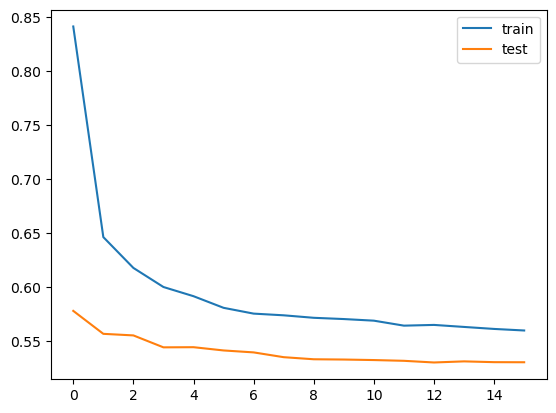

<Figure size 640x480 with 0 Axes>

In [25]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
pyplot.savefig('LSTM_combined_base_pool_aug.png')
model.save_weights('saved_models/LSTM_combined_base_pool_aug.h5', save_format = 'h5')

In [26]:
model_json = model.to_json()
with open('saved_models/LSTM_combined_base_pool_aug.json', 'w') as f:
    f.write(model_json)

In [27]:
from keras.models import model_from_json
with open('saved_models/LSTM_combined_base_pool_aug.json', 'r') as f:
    loaded_json = f.read()
    f.close()
    loaded_model = model_from_json(loaded_json)
loaded_model.load_weights('saved_models/LSTM_combined_base_pool_aug.h5')

In [28]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 450)]             0         
                                                                 
 embedding (Embedding)       (None, 450, 50)           868900    
                                                                 
 lstm (LSTM)                 (None, 450, 128)          91648     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                             

In [29]:
loaded_model.compile(optimizer=optimizer_obj, loss=mean_columnwise_root_mean_squared_error)
scores = loaded_model.evaluate(x_val_padded, y_val, verbose=0)
print("Validation loss: %.2f%%" % (scores*100))

Validation loss: 53.08%


In [30]:
test_scores = loaded_model.predict(x_val_padded)
print("Predicted results: ", test_scores[:10])
print("Actual results: ", y_val[:10])

13/13 [==============================] - 6s 224ms/step
Predicted results:  [[3.1216974 3.0336199 3.2291765 3.091684  2.966632  3.1292207]
 [3.3728833 3.2661345 3.416493  3.306389  3.2622604 3.4069102]
 [3.14      2.9725065 3.2260973 3.0501382 2.9093528 3.103533 ]
 [2.9468331 2.8562171 3.1116142 2.9706125 2.8381846 2.84458  ]
 [2.880649  2.7918122 2.9272351 2.8367214 2.8764484 3.0076349]
 [2.9688778 2.8377337 3.0592403 2.9092572 2.8828423 2.9188378]
 [2.9594307 2.8971906 3.0426795 2.9816213 2.901914  3.0347722]
 [3.3518188 3.2894793 3.5620766 3.4323993 3.299649  3.380713 ]
 [3.2100387 3.1095219 3.2983665 3.207966  3.2011678 3.1872156]
 [3.403983  3.2751002 3.4997544 3.385719  3.208535  3.3388634]]
Actual results:  [[3.  3.  3.  3.  2.5 3. ]
 [3.  3.  3.5 2.  2.  3. ]
 [3.5 2.5 2.5 3.  3.5 2.5]
 [3.5 3.  3.5 4.  3.5 3. ]
 [3.5 3.  2.5 3.  3.  2.5]
 [2.5 2.  2.  2.  2.  2. ]
 [2.5 2.5 3.  3.  2.  2. ]
 [2.5 2.5 3.  2.5 2.  2.5]
 [3.  4.  3.5 3.5 3.  3.5]
 [3.  3.  3.5 3.  2.5 3. ]]


In [31]:
test_scores[1].shape

(6,)

In [32]:
results_df = pd.DataFrame(data = list(zip(test_scores, y_val)), columns = ['Pred_scores', 'Actual'])
results_df.to_csv("LSTM_combined_base_pool_aug.csv")

In [33]:
analysis_df = results_df
analysis_df['error'] = results_df['Pred_scores'] - results_df['Actual']
analysis_df.to_csv("LSTM_combined_base_pool_aug.csv")
analysis_df.to_pickle("LSTM_combined_base_pool_aug.pkl")

### Analysis starts here.

In [34]:
analysis_df = pd.read_pickle("LSTM_combined_base_pool_aug.pkl")

In [35]:
analysis_df.head()

,Pred_scores,Actual,error
0,"[3.1216974, 3.0336199, 3.2291765, 3.091684, 2....","[3.0, 3.0, 3.0, 3.0, 2.5, 3.0]","[0.12169742584228516, 0.03361988067626953, 0.2..."
1,"[3.3728833, 3.2661345, 3.416493, 3.306389, 3.2...","[3.0, 3.0, 3.5, 2.0, 2.0, 3.0]","[0.37288331985473633, 0.26613450050354004, -0...."
2,"[3.14, 2.9725065, 3.2260973, 3.0501382, 2.9093...","[3.5, 2.5, 2.5, 3.0, 3.5, 2.5]","[-0.3599998950958252, 0.4725065231323242, 0.72..."
3,"[2.9468331, 2.8562171, 3.1116142, 2.9706125, 2...","[3.5, 3.0, 3.5, 4.0, 3.5, 3.0]","[-0.5531668663024902, -0.1437828540802002, -0...."
4,"[2.880649, 2.7918122, 2.9272351, 2.8367214, 2....","[3.5, 3.0, 2.5, 3.0, 3.0, 2.5]","[-0.6193509101867676, -0.20818781852722168, 0...."


In [36]:
pred_lst = analysis_df.Pred_scores
actual_lst = analysis_df.Actual
#cohesion 	syntax 	vocabulary 	phraseology 	grammar 	conventions

In [37]:
# flat is faster than item
cohesion_pred_lst = [x.flat[0] for x in pred_lst]
cohesion_act_lst = [x.flat[0] for x in actual_lst]

syntax_pred_lst = [x.flat[1] for x in pred_lst]
syntax_act_lst = [x.flat[1] for x in actual_lst]

vocabulary_pred_lst = [x.flat[2] for x in pred_lst]
vocabulary_act_lst = [x.flat[2] for x in actual_lst]

phraseology_pred_lst = [x.flat[3] for x in pred_lst]
phraseology_act_lst = [x.flat[3] for x in actual_lst]

grammar_pred_lst = [x.flat[4] for x in pred_lst]
grammar_act_lst = [x.flat[4] for x in actual_lst]

conventions_pred_lst = [x.flat[5] for x in pred_lst]
conventions_act_lst = [x.flat[5] for x in actual_lst]

In [73]:
#cohesion_pred = np.histogram(analysis_df['Pred_scores'][0][0])
#plt.hist(cohesion_pred)
# Follows a similar distribution to the actual scores.

In [72]:
#cohesion_actual = np.histogram(analysis_df['Actual'][0][0])
#plt.hist(cohesion_actual)

In [7]:
#pip install statsmodels

In [39]:
#import statsmodels.api as sm
#import pylab as py
#sm.qqplot(data = analysis_df['Actual'], line ='45')
#py.show()

In [40]:
#sm.qqplot(data = analysis_df['Pred_scores'], line ='45')
#py.show()

In [69]:
# Predicted scores are not normally distributed. Model is learning something 
# other than the normal distribution. Good news!

In [43]:
iterations = x_val_padded.shape[0]
print(iterations)
# Should be equal to 196 for non-augmented.

392


In [44]:
nonzero_count = []
for num in range(iterations):
    nonzero_count.append(np.count_nonzero(x_val_padded[num]))

In [45]:
proof_df = analysis_df
proof_df['nonzero'] = nonzero_count

In [46]:
pred_scores = np.array((pred_lst))
act_scores = np.array((actual_lst))
print(pred_scores[:5])

[array([3.1216974, 3.0336199, 3.2291765, 3.091684 , 2.966632 , 3.1292207],
       dtype=float32)
 array([3.3728833, 3.2661345, 3.416493 , 3.306389 , 3.2622604, 3.4069102],
       dtype=float32)
 array([3.14     , 2.9725065, 3.2260973, 3.0501382, 2.9093528, 3.103533 ],
       dtype=float32)
 array([2.9468331, 2.8562171, 3.1116142, 2.9706125, 2.8381846, 2.84458  ],
       dtype=float32)
 array([2.880649 , 2.7918122, 2.9272351, 2.8367214, 2.8764484, 3.0076349],
       dtype=float32)                                                     ]


<AxesSubplot:>

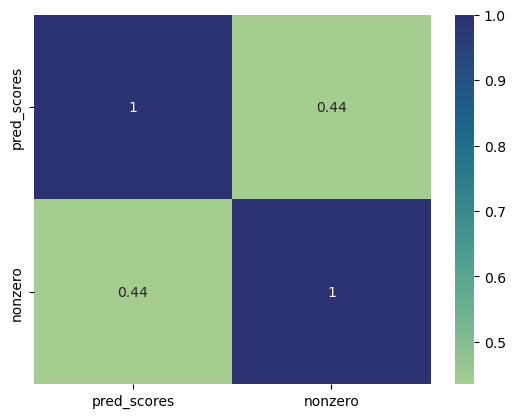

In [47]:
analysis_df['nonzero'] = nonzero_count

pred_scores_mean = [x.mean() for x in pred_scores]
pred_scores_mean[:5]

corr_df = pd.DataFrame({'pred_scores' : pred_scores_mean, 'nonzero' : nonzero_count})

import seaborn as sns
sns.heatmap(corr_df.corr(), annot = True, cmap = "crest")

### The base pooled LSTM model does observe a somewhat high correlation (0.41) between non-zero count and predicted scores.
### Augmented further strengthens that correlation.

#### Actual correlation:

<AxesSubplot:>

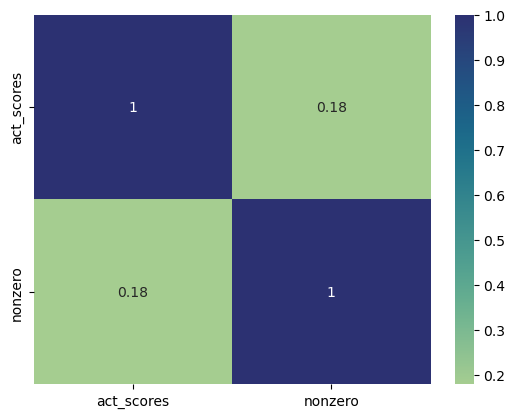

In [48]:
act_scores_mean = [x.mean() for x in act_scores]
act_corr_df = pd.DataFrame({'act_scores' : act_scores_mean, 'nonzero' : nonzero_count})
sns.heatmap(act_corr_df.corr(), annot = True, cmap = "crest")

#### This model maps the correlation a bit stronger than it really is.
### Also, the input data has been corrupted by augmentation because this correlation dropped from 0.31 to 0.18.

### Plotting the mean of the actual and mean of the predicted scores.

array([[<AxesSubplot:title={'center':'act_scores'}>]], dtype=object)

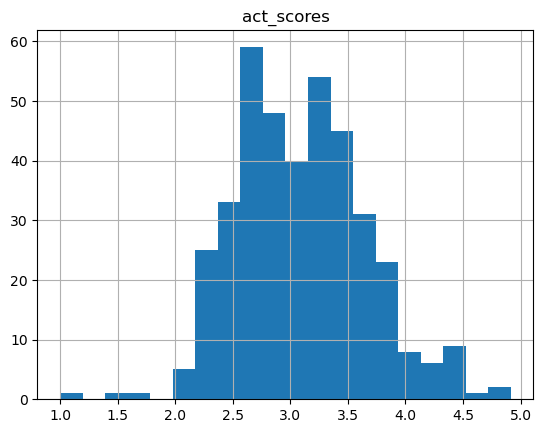

In [49]:
act_corr_df.hist(column = 'act_scores', bins = 20)

array([[<AxesSubplot:title={'center':'pred_scores'}>]], dtype=object)

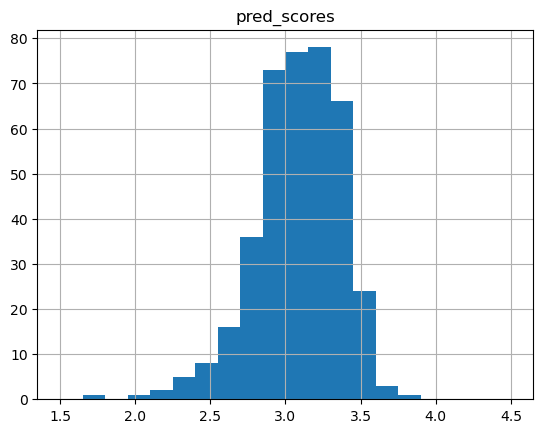

In [50]:
corr_df.hist(column = 'pred_scores', bins = 20, range = [1.5, 4.5])

### Our model's output seem to not be as evenly distributed. Augmentation makes this slightly healthier though.

In [51]:
pred_median_lst = [np.median(x) for x in pred_lst]
pred_med = np.median(pred_median_lst)

act_median_lst = [np.median(x) for x in actual_lst]
act_med = np.median(act_median_lst)

print("Pred median : ", pred_med)
print("Actual median : ", act_med)

Pred median :  3.1089468
Actual median :  3.0


In [52]:
pred_var_lst = [np.var(x) for x in pred_lst]
act_var_lst = [np.var(x) for x in actual_lst]

#print(pred_var_lst)

pred_var = np.mean(pred_var_lst)
act_var = np.mean(act_var_lst)

print("Pred mean variance : ", pred_var)
print("Actual mean variance : ", act_var)

Pred mean variance :  0.008753107
Actual mean variance :  0.11784297052154194


### Variance of the model's results is too low, as expected from looking at the graph.

### Does the model's predicted score roughly follow the actual scores?

In [53]:
corr_df_cohesion = pd.DataFrame({'pred_score' : cohesion_pred_lst, 'act_scores' : cohesion_act_lst})
corr_df_syntax = pd.DataFrame({'pred_score' : syntax_pred_lst, 'act_scores' : syntax_act_lst})
corr_df_vocabulary = pd.DataFrame({'pred_score' : vocabulary_pred_lst, 'act_scores' : vocabulary_act_lst})
corr_df_phraseology = pd.DataFrame({'pred_score' : phraseology_pred_lst, 'act_scores' : phraseology_act_lst})
corr_df_grammar = pd.DataFrame({'pred_score' : grammar_pred_lst, 'act_scores' : grammar_act_lst})
corr_df_conventions = pd.DataFrame({'pred_score' : conventions_pred_lst, 'act_scores' : conventions_act_lst})

Text(0.5, 1.0, 'Cohesion correlation')

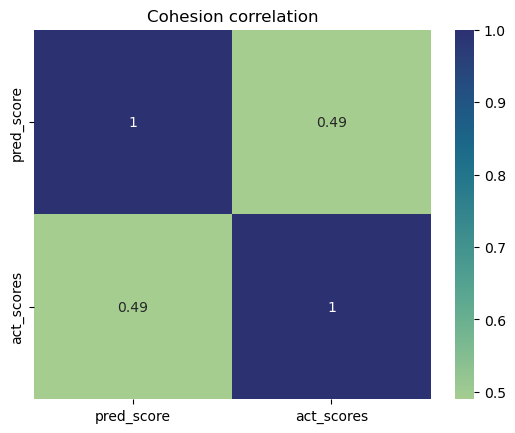

In [54]:
import seaborn as sns
sns.heatmap(corr_df_cohesion.corr(), annot = True, cmap = "crest").set_title("Cohesion correlation")

Text(0.5, 1.0, 'Syntax correlation')

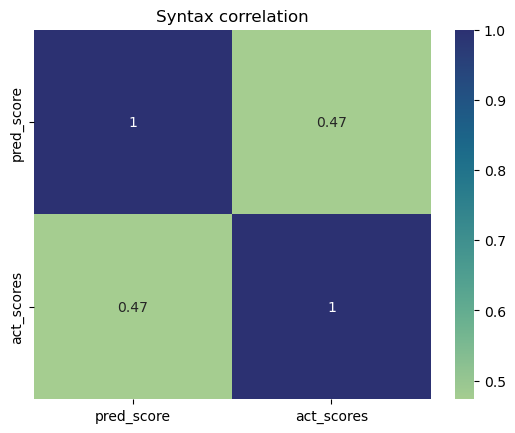

In [55]:
sns.heatmap(corr_df_syntax.corr(), annot = True, cmap = "crest").set_title("Syntax correlation")

Text(0.5, 1.0, 'Vocabulary correlation')

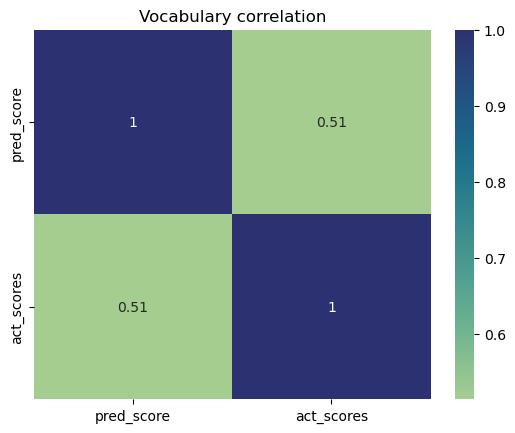

In [56]:
sns.heatmap(corr_df_vocabulary.corr(), annot = True, cmap = "crest").set_title("Vocabulary correlation")

Text(0.5, 1.0, 'Phraseology correlation')

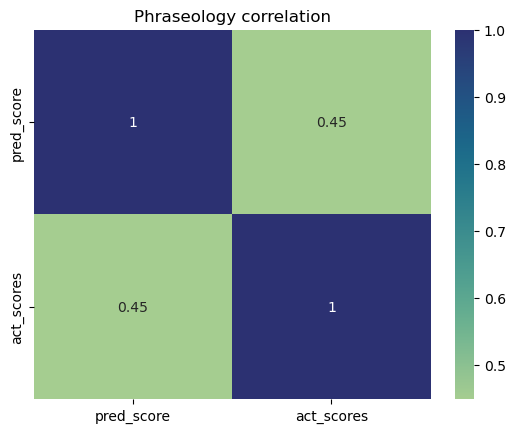

In [57]:
sns.heatmap(corr_df_phraseology.corr(), annot = True, cmap = "crest").set_title("Phraseology correlation")

Text(0.5, 1.0, 'Grammar correlation')

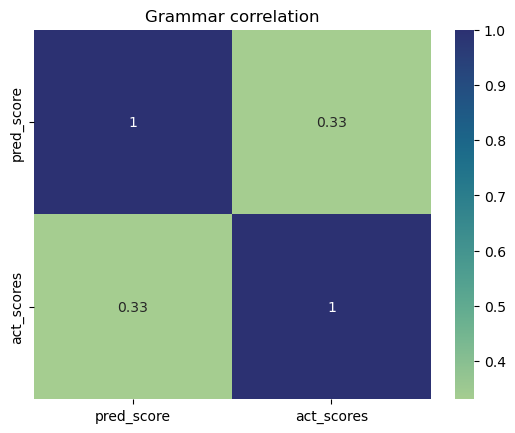

In [58]:
sns.heatmap(corr_df_grammar.corr(), annot = True, cmap = "crest").set_title("Grammar correlation")

Text(0.5, 1.0, 'Conventions correlation')

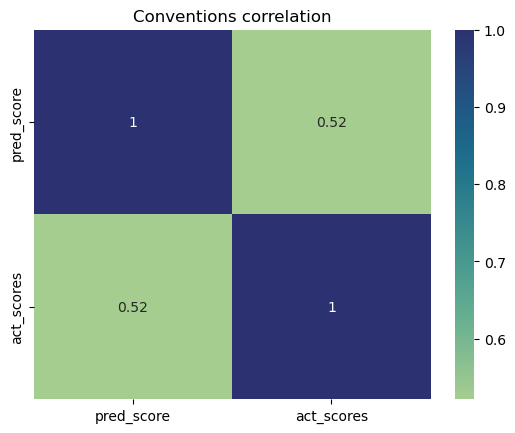

In [59]:
sns.heatmap(corr_df_conventions.corr(), annot = True, cmap = "crest").set_title("Conventions correlation")

### This model also seems to perform best with conventions and does not perform too well in grammar, phraseology, vocabulary and convention.

### The augmentation has made all the correlations stronger (as expected from the model fitting essentially the same data twice), but it still scores the same on the competition dataset. Further augmentation would likely promote overfitting.

In [ ]:
## Well, at least the correlation went down in pre-padding.
# Pre-padding, no masking : 43.44% loss!
# 0.49 correlation

# Pre-padding, masking: 40.99% loss!
# 0.59 correlation - some reason masking makes the length correlation stronger

In [ ]:
## This time around the correlation changed to 0.65.